# Hourly Time Series Forecasting using Facebook's Prophet

In this notebook we will use facebook's prophet package to forecast hourly energy use. 

1. Import useful libraries

In [1]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -q fsspec
!pip install -q s3fs

In [3]:
import numpy as np
import pandas as pd

from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on colab

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the `PJM East` which has data from 2002-2018 for the entire east region.

2. import the data thanks to the following link : ```https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+Supervis%C3%A9/time_series/PJME_hourly.csv`` make sure to use the arguments ```index_col=[0], parse_dates=[0]``` and remove all dates previous to january the first 2008

In [4]:
pjme = pd.read_csv('https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+Supervis%C3%A9/time_series/PJME_hourly.csv',
                   index_col=[0], parse_dates=[0]) # We set the index column and know it has dates

start_date = '01-Jan-2008'
pjme = pjme.loc[pjme.index >= start_date]
pjme = pjme[~pjme.index.duplicated()] # Remove duplicate indices
pjme.head()

PJME_MW
Datetime                    
2008-01-01 00:00:00  30998.0
2008-12-31 01:00:00  28937.0
2008-12-31 02:00:00  27714.0
2008-12-31 03:00:00  27120.0
2008-12-31 04:00:00  26995.0

3. Plot the time series

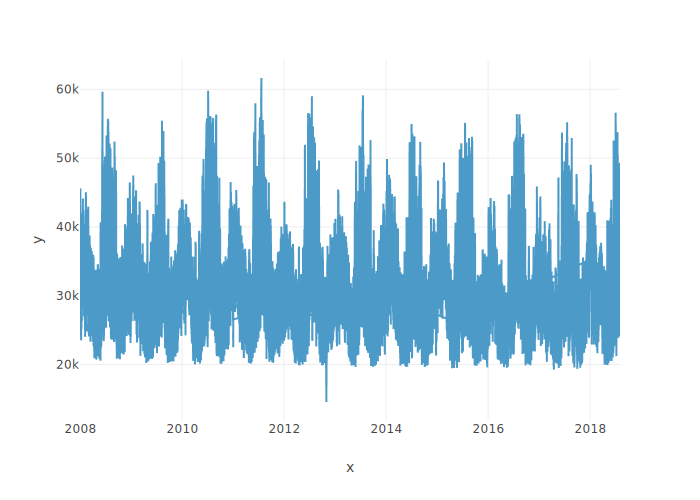

In [5]:
fig = px.line(x=pjme.index, y = pjme["PJME_MW"])
fig.show()

# EDA

4. Create this collection of new variables :
* ```date``` equal to the index
* ```hour``` equal to the hour of the day
* ```dayofweek```
* ```quarter```
* ```month```
* ```year```
* ```dayofyear```
* ```dayofmonth```
* ```weekofyear```

Create an object X containing the above variables and y containing the time series

In [6]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



5. Create an object features_and_target containing both and display the first few lines

In [7]:
# See our features and target
features_and_target.head()

hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2008-01-01 00:00:00     0          1        1      1  2008          1   
2008-12-31 01:00:00     1          2        4     12  2008        366   
2008-12-31 02:00:00     2          2        4     12  2008        366   
2008-12-31 03:00:00     3          2        4     12  2008        366   
2008-12-31 04:00:00     4          2        4     12  2008        366   

                     dayofmonth  weekofyear  PJME_MW  
Datetime                                              
2008-01-01 00:00:00           1           1  30998.0  
2008-12-31 01:00:00          31           1  28937.0  
2008-12-31 02:00:00          31           1  27714.0  
2008-12-31 03:00:00          31           1  27120.0  
2008-12-31 04:00:00          31           1  26995.0

## Plotting the Features to see trends

6. Plot the time series against hour, dayofweek, weekofyear, year


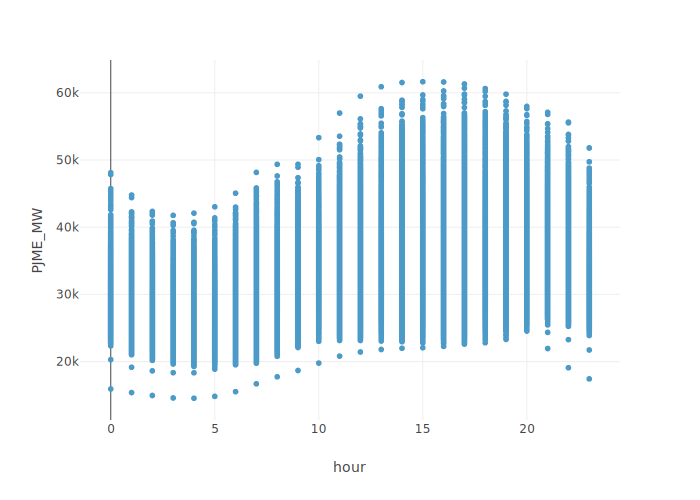

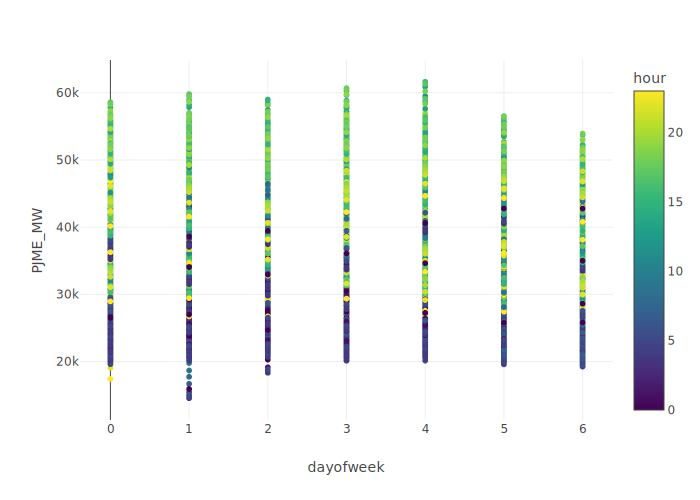

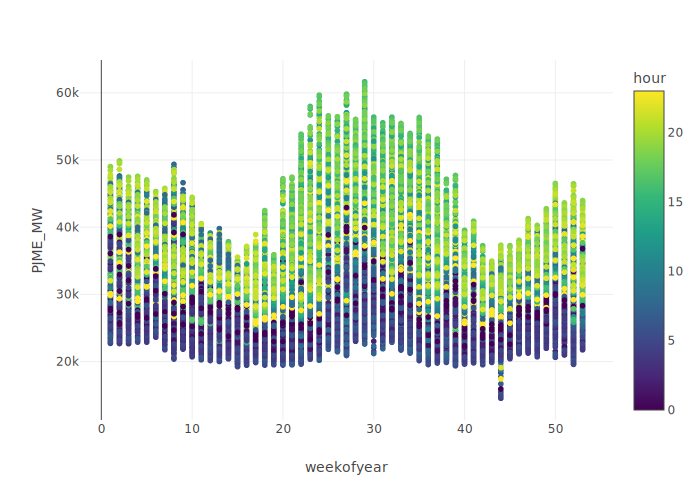

In [8]:
fig = px.scatter(features_and_target, x = 'hour', y = 'PJME_MW')
fig.show()
fig = px.scatter(features_and_target, x = 'dayofweek', y = 'PJME_MW', color = 'hour')
fig.show()
fig = px.scatter(features_and_target, x = 'weekofyear', y = 'PJME_MW', color = 'hour')
fig.show()
fig = px.scatter(features_and_target, x = 'year', y = 'PJME_MW', color = 'hour')
fig.show()

# Train/Test Split
7. Cut off the data after 2015 to use as our validation set. We will train on earlier data.

In [9]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

8. plot the series with different colors for the train and test set to visualize the separation.

In [10]:
fig = px.line(x = pjme_train.index, y = pjme_train["PJME_MW"])
fig.add_trace(px.line(x = pjme_test.index, y = pjme_test["PJME_MW"]).data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

# Simple Prophet Model
9. In pjme_train rename the Datetime variable "ds" and PJME_MW "y" to fit into the Prophet framework

In [11]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'})
pjme_train_prophet.head()

ds        y
0 2008-01-01 00:00:00  30998.0
1 2008-12-31 01:00:00  28937.0
2 2008-12-31 02:00:00  27714.0
3 2008-12-31 03:00:00  27120.0
4 2008-12-31 04:00:00  26995.0

10. Create an instance of the Prophet model and fit it on the train data.

In [12]:
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train_prophet)

11. Make predictions with your trained default prophet model on the test set

In [13]:
# Predict on training set with model
pjme_test_prophet = pjme_test.reset_index().rename(columns={'Datetime':'ds'})
pjme_test_fcst = model.predict(df=pjme_test_prophet)

In [14]:
pjme_test_fcst.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2015-01-01 01:00:00  30845.707861  25706.072652  34166.407513  30845.707861   
1 2015-01-01 02:00:00  30845.586941  24078.688945  32991.280252  30845.586941   
2 2015-01-01 03:00:00  30845.466021  23418.836426  31911.010546  30845.466021   
3 2015-01-01 04:00:00  30845.345101  22869.941221  31906.398097  30845.345101   
4 2015-01-01 05:00:00  30845.224180  23386.789871  32206.388814  30845.224180   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  30845.707861    -1058.006891          -1058.006891          -1058.006891   
1  30845.586941    -2533.105908          -2533.105908          -2533.105908   
2  30845.466021    -3388.756740          -3388.756740          -3388.756740   
3  30845.345101    -3514.011912          -3514.011912          -3514.011912   
4  30845.224180    -2823.004121          -2823.004121          -2823.004121   

         daily  ...       weekly  weekly_lower  weekly_upper       yearly  \
0 -4352.128499  ...  1236.832055   1236.832055   1236.832055  2057.289552   
1 -5821.686813  ...  1228.695583   1228.695583   1228.695583  2059.885323   
2 -6670.489843  ...  1219.226290   1219.226290   1219.226290  2062.506813   
3 -6787.699266  ...  1208.533328   1208.533328   1208.533328  2065.154027   
4 -6087.568803  ...  1196.737716   1196.737716   1196.737716  2067.826966   

   yearly_lower  yearly_upper  multiplicative_terms  \
0   2057.289552   2057.289552                   0.0   
1   2059.885323   2059.885323                   0.0   
2   2062.506813   2062.506813                   0.0   
3   2065.154027   2065.154027                   0.0   
4   2067.826966   2067.826966                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  29787.700970  
1                         0.0                         0.0  28312.481033  
2                         0.0                         0.0  27456.709281  
3                         0.0                         0.0  27331.333189  
4                         0.0                         0.0  28022.220059  

[5 rows x 22 columns]

13. Plot the trend, the yearly seasonnality, the weekly seasonnality, and the daily seasonnality.

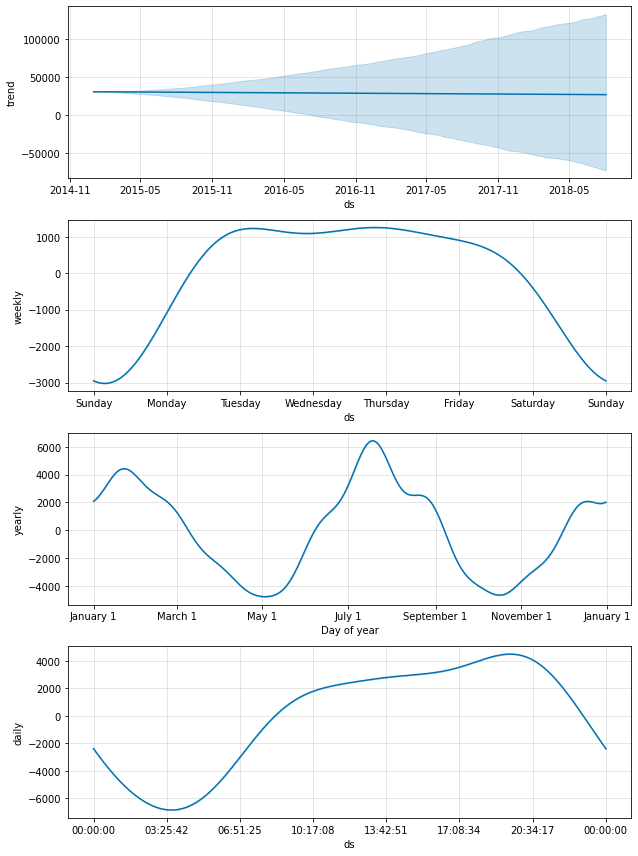

In [15]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

# Compare Forecast to Actuals

14. Plot the forcasts against the actual values in the test set.

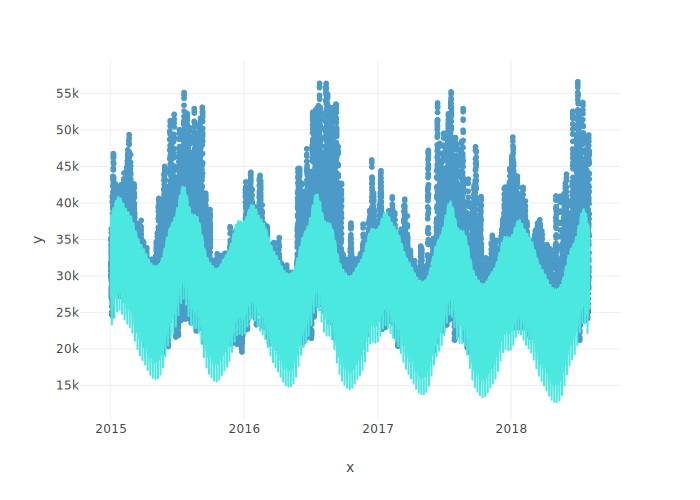

In [16]:
fig = px.scatter(x = pjme_test.index, y = pjme_test['PJME_MW'])
fig.add_trace(px.line(pjme_test_fcst, x="ds", y="yhat").data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

# Look at first month of predictions

15. Compare in a graph predictions for the first month against reality.

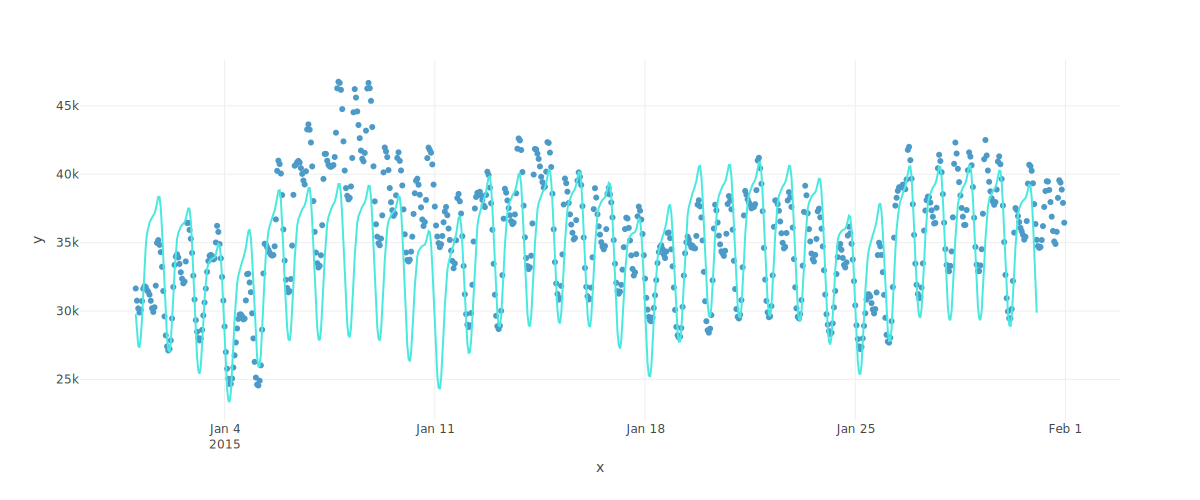

In [17]:
mask = (pjme_test.index >= '01-01-2015') & (pjme_test.index < '02-01-2015')
fig = px.scatter(x = pjme_test.loc[mask,:].index, y = pjme_test.loc[mask,'PJME_MW'], width = 1200)
fig.add_trace(px.line(pjme_test_fcst.loc[0:30*24,:], x="ds", y="yhat").data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

# Single Week of Predictions

16. plot the first week of data against the model's predictions

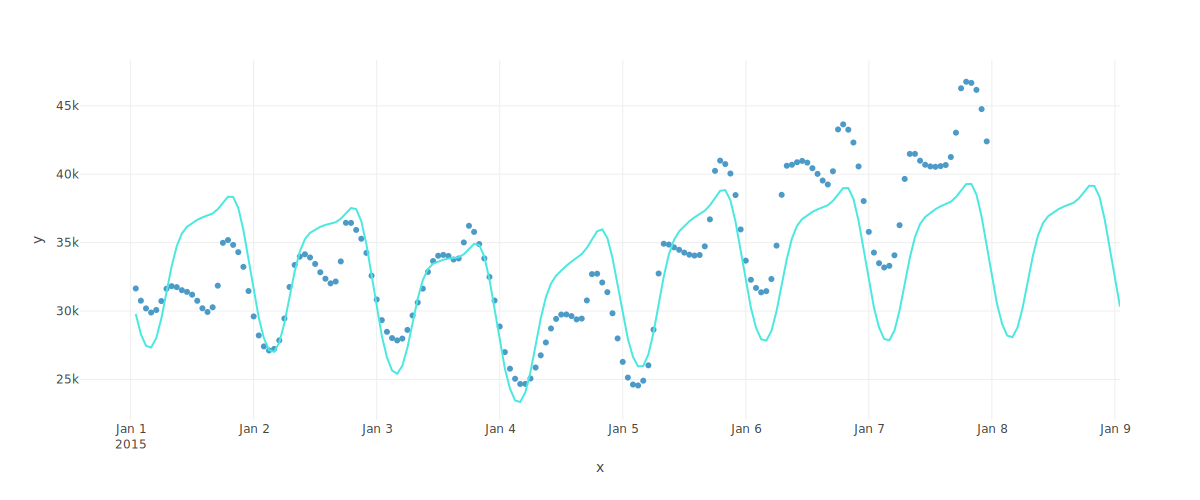

In [18]:
mask = (pjme_test.index >= '01-01-2015') & (pjme_test.index < '01-08-2015')
fig = px.scatter(x = pjme_test.loc[mask,:].index, y = pjme_test.loc[mask,'PJME_MW'], width = 1200)
fig.add_trace(px.line(pjme_test_fcst.loc[0:8*24,:], x="ds", y="yhat").data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

17. Calculate the MSE, the MAE and the MAPE (mean obsolute percentage error) for this model over the test dataset
$$MAPE = \frac{1}{n}\sum_{t=1}^{n}|\frac{Y_t - \hat{Y_t}}{Y_t}|$$

In [19]:
mse = mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

print("The MSE on the test set is : \n {}".format(mse))

The MSE on the test set is : 
 46471087.94873971


In [20]:
mae = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

print("The MAE on the test set is : \n {}".format(mae))

The MAE on the test set is : 
 5327.881441554647


In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

print("The MAPE on the test set is : \n {}".format(mape))

The MAPE on the test set is : 
 16.501205418693875


# Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a *Holiday Effects* parameter that can be provided to the model prior to training. 

We will use the built in pandas `USFederalHolidayCalendar` to pull the list of holidays

18. Create a test_holidays object containing the us federal holidays for the considered test period and an object train_holidays for the considered train period.

In [22]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(),
                              end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(),
                             end=pjme_test.index.max())

19. Create a DataFrame contaning all holidays over the observed period with a ds column with the dates and a holiday column with the holidays and convert ds column to datetime format.

In [23]:
# Create a dataframe with holiday, ds columns
pjme['date'] = pjme.index.date
pjme['is_holiday'] = pjme.date.isin([d.date() for d in cal.holidays()])
holiday_df = pjme.loc[pjme['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

ds           holiday
0 2008-01-01 00:00:00  USFederalHoliday
1 2009-01-01 00:00:00  USFederalHoliday
2 2008-12-25 01:00:00  USFederalHoliday
3 2008-12-25 02:00:00  USFederalHoliday
4 2008-12-25 03:00:00  USFederalHoliday

In [24]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

20. Create an instance of the Prophet model with ```holidays = holiday_df``` the DataFrame we have just created, and train that model on the training set.

In [25]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

## Predict With Holidays

21. Make predictions for the test set with the holiday model

In [26]:
# Predict on training set with model
pjme_test_fcst_with_hols = model_with_holidays.predict(df=pjme_test_prophet)

## Plot Holiday Effect

22. Plot the different components of the holiday model

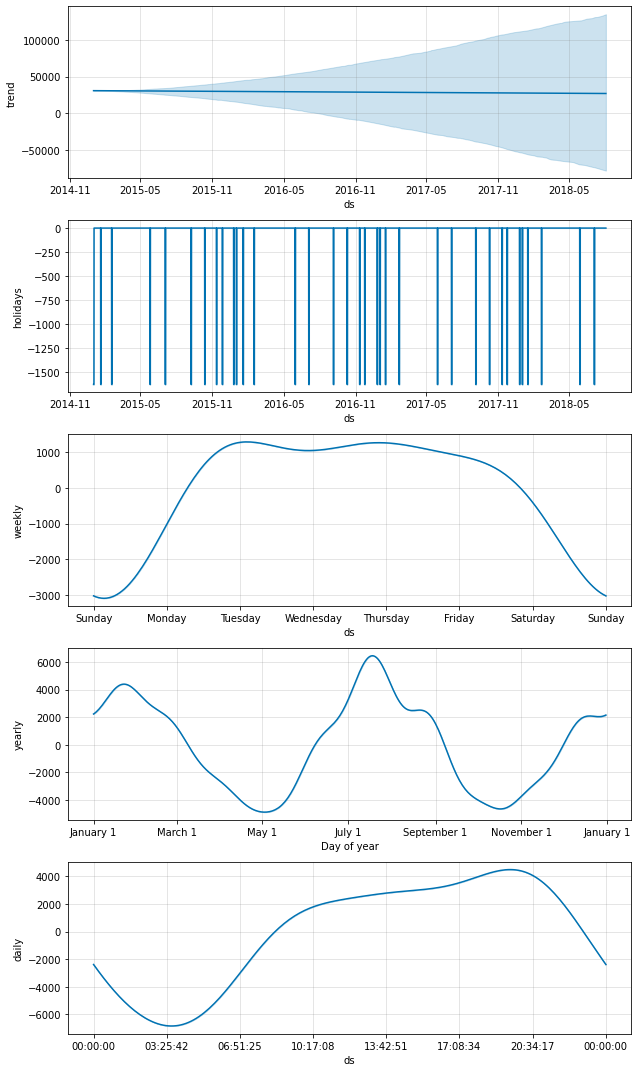

In [27]:
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_hols)

# Error Metrics with Holidays Added
23. Calculate the MSE, MAE and MAPE for the holiday model on the test set.

In [28]:
mse = mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

print("The MSE on the test set is : \n {}".format(mse))

The MSE on the test set is : 
 46708833.73505651


In [29]:
mae = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

print("The MAE on the test set is : \n {}".format(mae))

The MAE on the test set is : 
 5345.507641392378


In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

print("The MAPE on the test set is : \n {}".format(mape))

The MAPE on the test set is : 
 16.555899376151928
